# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Import Required Libraries 📚</h1></span>

In [1]:
!pip install torcheval
!pip install timm
!pip install albumentations
!pip install kagglehub

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import gc
import cv2
import math
import copy
import time
import random
import glob
from matplotlib import pyplot as plt

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torchvision
from torcheval.metrics.functional import binary_auroc

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold 

# For Image Models
import timm

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
import kagglehub

# Download latest version
path = kagglehub.model_download("timm/tf-efficientnet/pyTorch/tf-efficientnet-b0")

print("Path to model files:", path)

Path to model files: /usr4/cs640/abvo138/.cache/kagglehub/models/timm/tf-efficientnet/pyTorch/tf-efficientnet-b0/1


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Training Configuration ⚙️</h1></span>

In [4]:
'''CONFIG = {
    "seed": 42,
    "epochs": 50,
    "img_size": 384,
 #   "model_name": "tf_efficientnet_b0_ns",
    "model_name": "tf_efficientnet_b0", 
 #   "checkpoint_path" : "/kaggle/input/tf-efficientnet/pytorch/tf-efficientnet-b0/1/tf_efficientnet_b0_aa-827b6e33.pth",
    "checkpoint_path": "/usr4/cs640/abvo138/.cache/kagglehub/models/timm/tf-efficientnet/pyTorch/tf-efficientnet-b0/1", 
    "train_batch_size": 32,
    "valid_batch_size": 64,
    "learning_rate": 1e-4,
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 1e-6,
    "T_max": 500,
    "weight_decay": 1e-6,
    "fold" : 0,
    "n_fold": 5,
    "n_accumulate": 1,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
}'''


CONFIG = {
    "seed": 42,
    "epochs": 50,
    "img_size": 384,
    "model_name": "tf_efficientnet_b0_ns",
    "checkpoint_path": "tf_efficientnet_b0_aa-827b6e33.pth",
    "train_batch_size": 32,
    "valid_batch_size": 64,
    "learning_rate": 1e-4,
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 1e-6,
    "T_max": 500,
    "weight_decay": 1e-6,
    "fold": 0,
    "n_fold": 5,
    "n_accumulate": 1,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
}

# Load the EfficientNet Model with timm
model = timm.create_model(
    CONFIG["model_name"],  # Using model name from CONFIG
    pretrained=False,      # Do not load the pretrained weights from the internet
    checkpoint_path=CONFIG["checkpoint_path"]  # Load weights from the local checkpoint
)

# Set the model to evaluation mode
model.eval()

# Move the model to the device
model.to(CONFIG["device"])

print("Model loaded successfully!")

Model loaded successfully!


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Set Seed for Reproducibility</h1></span>

In [5]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

In [6]:
'''
project_dir = os.path.join(os.sep, 'projectnb', 'cs640grp', 'materials', 'ISIC-2024_CS640')
df_train = pandas.read_csv(os.path.join(project_dir, "train_metadata.csv"))
'''

ROOT_DIR = os.path.join(os.sep, 'projectnb', 'cs640grp', 'materials', 'ISIC-2024_CS640')
TRAIN_DIR = f'{ROOT_DIR}/train_image'

In [7]:
def get_train_file_path(image_id):
    return f"{TRAIN_DIR}/{image_id}.jpg"

# <h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Read the Data 📖</h1>

In [8]:
train_images = sorted(glob.glob(f"{TRAIN_DIR}/*.jpg"))

In [9]:
df = pd.read_csv(f"{ROOT_DIR}/train_metadata.csv")

df.columns

Index(['id', 'target', 'age_approx', 'sex', 'anatom_site_general',
       'clin_size_long_diam_mm', 'tbp_tile_type', 'tbp_lv_A', 'tbp_lv_Aext',
       'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H',
       'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2',
       'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'tbp_lv_deltaA',
       'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB',
       'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_location',
       'tbp_lv_location_simple', 'tbp_lv_minorAxisMM',
       'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color',
       'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL',
       'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle',
       'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z'],
      dtype='object')

In [10]:
df = pd.read_csv(f"{ROOT_DIR}/train_metadata.csv")

# print("        df.shape, # of positive cases, # of patients")
# print("original>", df.shape, df.target.sum(), df["patient_id"].unique().shape)

df_positive = df[df["target"] == 1].reset_index(drop=True)
df_negative = df[df["target"] == 0].reset_index(drop=True)

df = pd.concat([df_positive, df_negative.iloc[:df_positive.shape[0]*20, :]])  # positive:negative = 1:20
# print("filtered>", df.shape, df.target.sum(), df["patient_id"].unique().shape)
df['file_path'] = df['id'].apply(get_train_file_path)
df = df[ df["file_path"].isin(train_images) ].reset_index(drop=True)
df


,id,target,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,...,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,file_path
0,459,1,65.0,male,posterior torso,10.82,3D: white,20.871160,16.610670,20.523050,...,28.643210,3.136121,9.403855,2.356120,0.171552,175,-148.532300,1066.751000,121.249200,/projectnb/cs640grp/materials/ISIC-2024_CS640/...
1,690,1,60.0,male,anterior torso,3.12,3D: XP,31.926363,25.735510,37.727808,...,10.516377,0.915965,1.677692,3.642767,0.598802,110,28.257790,1131.117920,88.584473,/projectnb/cs640grp/materials/ISIC-2024_CS640/...
2,1118,1,55.0,male,lower extremity,12.66,3D: white,20.391100,14.721510,18.167190,...,56.597460,3.671458,4.827992,4.352363,0.259780,20,167.630600,312.628200,102.853400,/projectnb/cs640grp/materials/ISIC-2024_CS640/...
3,1655,1,70.0,female,lower extremity,2.19,3D: XP,19.693810,14.603610,31.681380,...,7.369725,1.052949,2.229226,2.184116,0.130435,130,-194.177700,338.241100,29.611270,/projectnb/cs640grp/materials/ISIC-2024_CS640/...
4,1762,1,80.0,male,anterior torso,5.18,3D: white,14.233970,13.405580,14.309860,...,23.484740,2.690731,4.170507,3.846216,0.471311,95,54.181710,1165.629000,-95.257320,/projectnb/cs640grp/materials/ISIC-2024_CS640/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6589,6283,0,55.0,female,head/neck,3.38,3D: XP,26.478243,22.595322,24.804616,...,9.420487,0.319733,1.072940,3.110400,0.441860,75,11.395874,1292.966675,-78.625854,/projectnb/cs640grp/materials/ISIC-2024_CS640/...
6590,6284,0,60.0,male,anterior torso,3.01,3D: XP,20.181710,16.264490,34.406610,...,8.532092,0.144892,2.274721,1.706717,0.366972,90,163.926900,1489.495000,7.309753,/projectnb/cs640grp/materials/ISIC-2024_CS640/...
6591,6285,0,65.0,male,upper extremity,4.04,3D: white,25.950790,19.740780,25.738300,...,12.968360,1.388929,3.531413,2.779279,0.291829,10,265.506100,1444.390000,49.615170,/projectnb/cs640grp/materials/ISIC-2024_CS640/...
6592,6286,0,55.0,female,lower extremity,4.53,3D: XP,17.640935,13.361522,24.988712,...,12.293166,2.321691,2.893916,1.905315,0.240418,155,128.747864,441.536255,37.841492,/projectnb/cs640grp/materials/ISIC-2024_CS640/...


In [11]:
df.shape[0], df.target.sum()

(6594, 314)

In [12]:
CONFIG['T_max'] = df.shape[0] * (CONFIG["n_fold"]-1) * CONFIG['epochs'] // CONFIG['train_batch_size'] // CONFIG["n_fold"]
CONFIG['T_max']

8242

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Create Folds</h1></span>

In [13]:
'''
sgkf = StratifiedGroupKFold(n_splits=CONFIG['n_fold'])
for fold, ( _, val_) in enumerate(sgkf.split(df, df.target,df.patient_id)):
      df.loc[val_ , "kfold"] = int(fold)
'''

sgkf = StratifiedKFold(n_splits=CONFIG['n_fold'])
for fold, ( _, val_) in enumerate(sgkf.split(df, df.target)):
      df.loc[val_ , "kfold"] = int(fold)

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Dataset Class</h1></span>

In [14]:
class ISICDataset_for_Train(Dataset):
    def __init__(self, df, transforms=None):
        self.df_positive = df[df["target"] == 1].reset_index()
        self.df_negative = df[df["target"] == 0].reset_index()
        self.file_names_positive = self.df_positive['file_path'].values
        self.file_names_negative = self.df_negative['file_path'].values
        self.targets_positive = self.df_positive['target'].values
        self.targets_negative = self.df_negative['target'].values
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df_positive) * 2
    
    def __getitem__(self, index):
        if random.random() >= 0.5:
            df = self.df_positive
            file_names = self.file_names_positive
            targets = self.targets_positive
        else:
            df = self.df_negative
            file_names = self.file_names_negative
            targets = self.targets_negative
        index = index % df.shape[0]
        
        img_path = file_names[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        target = targets[index]
        
        if self.transforms:
            img = self.transforms(image=img)["image"]
            
        return {
            'image': img,
            'target': target
        }
    
class ISICDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.targets = df['target'].values
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path = self.file_names[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        target = self.targets[index]
        
        if self.transforms:
            img = self.transforms(image=img)["image"]
            
        return {
            'image': img,
            'target': target
        }

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Augmentations</h1></span>

In [15]:
data_transforms = {
    "train": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.RandomRotate90(p=0.5),
        A.Flip(p=0.5),
        A.Downscale(p=0.25),
        A.ShiftScaleRotate(shift_limit=0.1, 
                           scale_limit=0.15, 
                           rotate_limit=60, 
                           p=0.5),
        A.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
        A.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.),
    
    "valid": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.)
}

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">GeM Pooling</h1></span>

In [16]:
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + \
                '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
                ', ' + 'eps=' + str(self.eps) + ')'

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Create Model</h1></span>

In [17]:
class ISICModel(nn.Module):
    def __init__(self, model_name, num_classes=1, pretrained=True, checkpoint_path=None):
        super(ISICModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, checkpoint_path=checkpoint_path)

        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Identity()
        self.model.global_pool = nn.Identity()
        self.pooling = GeM()
        self.linear = nn.Linear(in_features, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, images):
        features = self.model(images)
        pooled_features = self.pooling(features).flatten(1)
        output = self.sigmoid(self.linear(pooled_features))
        return output

    
model = ISICModel(CONFIG['model_name'], checkpoint_path=CONFIG['checkpoint_path'])
model.to(CONFIG['device']);

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Loss Function</h1></span>

In [18]:
def criterion(outputs, targets):
    return nn.BCELoss()(outputs, targets)

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Training Function</h1></span>

In [19]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    running_auroc  = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        images = data['image'].to(device, dtype=torch.float)
        targets = data['target'].to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        outputs = model(images).squeeze()
        loss = criterion(outputs, targets)
        loss = loss / CONFIG['n_accumulate']
            
        loss.backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        auroc = binary_auroc(input=outputs.squeeze(), target=targets).item()
        
        running_loss += (loss.item() * batch_size)
        running_auroc  += (auroc * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        epoch_auroc = running_auroc / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss, Train_Auroc=epoch_auroc,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss, epoch_auroc

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Validation Function</h1></span>

In [20]:
@torch.inference_mode()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    running_auroc = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:        
        images = data['image'].to(device, dtype=torch.float)
        targets = data['target'].to(device, dtype=torch.float)
        
        batch_size = images.size(0)

        outputs = model(images).squeeze()
        loss = criterion(outputs, targets)

        auroc = binary_auroc(input=outputs.squeeze(), target=targets).item()
        running_loss += (loss.item() * batch_size)
        running_auroc  += (auroc * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        epoch_auroc = running_auroc / dataset_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss, Valid_Auroc=epoch_auroc,
                        LR=optimizer.param_groups[0]['lr'])   
    
    gc.collect()
    
    return epoch_loss, epoch_auroc

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Run Training</h1></span>

In [21]:
def run_training(model, optimizer, scheduler, device, num_epochs):
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_auroc = -np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss, train_epoch_auroc = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CONFIG['device'], epoch=epoch)
        
        val_epoch_loss, val_epoch_auroc = valid_one_epoch(model, valid_loader, device=CONFIG['device'], 
                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        history['Train AUROC'].append(train_epoch_auroc)
        history['Valid AUROC'].append(val_epoch_auroc)
        history['lr'].append( scheduler.get_lr()[0] )
        
        # deep copy the model
        if best_epoch_auroc <= val_epoch_auroc:
            print(f"{b_}Validation AUROC Improved ({best_epoch_auroc} ---> {val_epoch_auroc})")
            best_epoch_auroc = val_epoch_auroc
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = "AUROC{:.4f}_Loss{:.4f}_epoch{:.0f}.bin".format(val_epoch_auroc, val_epoch_loss, epoch)
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved{sr_}")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best AUROC: {:.4f}".format(best_epoch_auroc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [22]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None
        
    return scheduler

In [23]:
def prepare_loaders(df, fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = ISICDataset_for_Train(df_train, transforms=data_transforms["train"])
    valid_dataset = ISICDataset(df_valid, transforms=data_transforms["valid"])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], 
                              num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], 
                              num_workers=2, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

<span style="color: #000508; font-family: Segoe UI; font-size: 1.5em; font-weight: 300;">Prepare Dataloaders</span>

In [24]:
train_loader, valid_loader = prepare_loaders(df, fold=CONFIG["fold"])

<span style="color: #000508; font-family: Segoe UI; font-size: 1.5em; font-weight: 300;">Define Optimizer and Scheduler</span>

In [25]:
optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'], 
                       weight_decay=CONFIG['weight_decay'])
scheduler = fetch_scheduler(optimizer)

<span style="color: #000508; font-family: Segoe UI; font-size: 1.5em; font-weight: 300;">Start Training</span>

In [26]:
model, history = run_training(model, optimizer, scheduler,
                              device=CONFIG['device'],
                              num_epochs=CONFIG['epochs'])

[INFO] Using GPU: NVIDIA L40S



100%|██████████| 21/21 [00:02<00:00,  8.20it/s, Epoch=1, LR=0.0001, Valid_Auroc=0.493, Valid_Loss=0.587]


Validation AUROC Improved (-inf ---> 0.49345343393865004)
Model Saved



100%|██████████| 21/21 [00:01<00:00, 11.60it/s, Epoch=2, LR=0.0001, Valid_Auroc=0.499, Valid_Loss=0.579]


Validation AUROC Improved (0.49345343393865004 ---> 0.49884472363623233)
Model Saved



100%|██████████| 21/21 [00:01<00:00, 12.46it/s, Epoch=3, LR=0.0001, Valid_Auroc=0.511, Valid_Loss=0.483]


Validation AUROC Improved (0.49884472363623233 ---> 0.5111676715164206)
Model Saved



100%|██████████| 21/21 [00:01<00:00, 11.67it/s, Epoch=4, LR=0.0001, Valid_Auroc=0.515, Valid_Loss=0.533]


Validation AUROC Improved (0.5111676715164206 ---> 0.5150185927289794)
Model Saved



100%|██████████| 21/21 [00:01<00:00, 12.25it/s, Epoch=5, LR=0.0001, Valid_Auroc=0.519, Valid_Loss=0.603]


Validation AUROC Improved (0.5150185927289794 ---> 0.5188695139415382)
Model Saved



100%|██████████| 21/21 [00:01<00:00, 12.17it/s, Epoch=6, LR=0.0001, Valid_Auroc=0.519, Valid_Loss=0.562]


Validation AUROC Improved (0.5188695139415382 ---> 0.5188695139415382)
Model Saved



100%|██████████| 21/21 [00:01<00:00, 12.28it/s, Epoch=7, LR=0.0001, Valid_Auroc=0.517, Valid_Loss=0.503]


100%|██████████| 21/21 [00:01<00:00, 12.40it/s, Epoch=8, LR=9.99e-5, Valid_Auroc=0.52, Valid_Loss=0.437] 


Validation AUROC Improved (0.5188695139415382 ---> 0.5204098824265617)
Model Saved



100%|██████████| 21/21 [00:01<00:00, 12.42it/s, Epoch=9, LR=9.99e-5, Valid_Auroc=0.52, Valid_Loss=0.385] 


Validation AUROC Improved (0.5204098824265617 ---> 0.5204098824265617)
Model Saved



100%|██████████| 21/21 [00:01<00:00, 12.09it/s, Epoch=10, LR=9.99e-5, Valid_Auroc=0.521, Valid_Loss=0.537]


Validation AUROC Improved (0.5204098824265617 ---> 0.5211800666690735)
Model Saved



100%|██████████| 21/21 [00:01<00:00, 11.78it/s, Epoch=11, LR=9.99e-5, Valid_Auroc=0.52, Valid_Loss=0.39]  


100%|██████████| 21/21 [00:01<00:00, 12.09it/s, Epoch=12, LR=9.99e-5, Valid_Auroc=0.523, Valid_Loss=0.351]


Validation AUROC Improved (0.5211800666690735 ---> 0.522720435154097)
Model Saved



100%|██████████| 21/21 [00:01<00:00, 11.92it/s, Epoch=13, LR=9.99e-5, Valid_Auroc=0.523, Valid_Loss=0.436]


Validation AUROC Improved (0.522720435154097 ---> 0.5234906193966088)
Model Saved



100%|██████████| 21/21 [00:01<00:00, 12.08it/s, Epoch=14, LR=9.98e-5, Valid_Auroc=0.524, Valid_Loss=0.437]


Validation AUROC Improved (0.5234906193966088 ---> 0.5242608036391205)
Model Saved



100%|██████████| 21/21 [00:01<00:00, 12.33it/s, Epoch=15, LR=9.98e-5, Valid_Auroc=0.524, Valid_Loss=0.333]


Validation AUROC Improved (0.5242608036391205 ---> 0.5242608036391205)
Model Saved



100%|██████████| 21/21 [00:01<00:00, 12.17it/s, Epoch=16, LR=9.98e-5, Valid_Auroc=0.523, Valid_Loss=0.324]


100%|██████████| 21/21 [00:01<00:00, 11.86it/s, Epoch=17, LR=9.98e-5, Valid_Auroc=0.523, Valid_Loss=0.341]


100%|██████████| 21/21 [00:01<00:00, 12.11it/s, Epoch=18, LR=9.97e-5, Valid_Auroc=0.524, Valid_Loss=0.42] 


Validation AUROC Improved (0.5242608036391205 ---> 0.5242608036391205)
Model Saved



100%|██████████| 21/21 [00:01<00:00, 11.65it/s, Epoch=19, LR=9.97e-5, Valid_Auroc=0.524, Valid_Loss=0.39] 


Validation AUROC Improved (0.5242608036391205 ---> 0.5242608036391205)
Model Saved



100%|██████████| 21/21 [00:01<00:00, 12.16it/s, Epoch=20, LR=9.97e-5, Valid_Auroc=0.524, Valid_Loss=0.401]


Validation AUROC Improved (0.5242608036391205 ---> 0.5242608036391205)
Model Saved



100%|██████████| 21/21 [00:01<00:00, 11.95it/s, Epoch=21, LR=9.96e-5, Valid_Auroc=0.524, Valid_Loss=0.323]


Validation AUROC Improved (0.5242608036391205 ---> 0.5242608036391205)
Model Saved



100%|██████████| 21/21 [00:01<00:00, 11.94it/s, Epoch=22, LR=9.96e-5, Valid_Auroc=0.524, Valid_Loss=0.407]


Validation AUROC Improved (0.5242608036391205 ---> 0.5242608036391205)
Model Saved



100%|██████████| 21/21 [00:01<00:00, 11.47it/s, Epoch=23, LR=9.96e-5, Valid_Auroc=0.524, Valid_Loss=0.303]


Validation AUROC Improved (0.5242608036391205 ---> 0.5242608036391205)
Model Saved



100%|██████████| 21/21 [00:01<00:00, 12.21it/s, Epoch=24, LR=9.95e-5, Valid_Auroc=0.524, Valid_Loss=0.485]


Validation AUROC Improved (0.5242608036391205 ---> 0.5242608036391205)
Model Saved



100%|██████████| 21/21 [00:01<00:00, 11.39it/s, Epoch=25, LR=9.95e-5, Valid_Auroc=0.523, Valid_Loss=0.38] 


100%|██████████| 21/21 [00:01<00:00, 12.21it/s, Epoch=26, LR=9.95e-5, Valid_Auroc=0.523, Valid_Loss=0.388]


100%|██████████| 21/21 [00:01<00:00, 12.19it/s, Epoch=27, LR=9.94e-5, Valid_Auroc=0.524, Valid_Loss=0.275]


Validation AUROC Improved (0.5242608036391205 ---> 0.5242608036391205)
Model Saved



100%|██████████| 21/21 [00:01<00:00, 12.28it/s, Epoch=28, LR=9.94e-5, Valid_Auroc=0.524, Valid_Loss=0.495]


Validation AUROC Improved (0.5242608036391205 ---> 0.5242608036391205)
Model Saved



100%|██████████| 21/21 [00:01<00:00, 12.21it/s, Epoch=29, LR=9.93e-5, Valid_Auroc=0.523, Valid_Loss=0.392]


100%|██████████| 21/21 [00:01<00:00, 12.37it/s, Epoch=30, LR=9.93e-5, Valid_Auroc=0.524, Valid_Loss=0.388]


Validation AUROC Improved (0.5242608036391205 ---> 0.5242608036391205)
Model Saved



100%|██████████| 21/21 [00:01<00:00, 12.52it/s, Epoch=31, LR=9.92e-5, Valid_Auroc=0.523, Valid_Loss=0.541]


100%|██████████| 21/21 [00:01<00:00, 12.59it/s, Epoch=32, LR=9.92e-5, Valid_Auroc=0.524, Valid_Loss=0.367]


Validation AUROC Improved (0.5242608036391205 ---> 0.5242608036391205)
Model Saved



100%|██████████| 21/21 [00:01<00:00, 12.37it/s, Epoch=33, LR=9.91e-5, Valid_Auroc=0.523, Valid_Loss=0.501]


100%|██████████| 21/21 [00:01<00:00, 12.48it/s, Epoch=34, LR=9.91e-5, Valid_Auroc=0.524, Valid_Loss=0.431]


Validation AUROC Improved (0.5242608036391205 ---> 0.5242608036391205)
Model Saved



100%|██████████| 21/21 [00:01<00:00, 12.55it/s, Epoch=35, LR=9.9e-5, Valid_Auroc=0.524, Valid_Loss=0.566]


Validation AUROC Improved (0.5242608036391205 ---> 0.5242608036391205)
Model Saved



100%|██████████| 21/21 [00:01<00:00, 12.32it/s, Epoch=36, LR=9.9e-5, Valid_Auroc=0.524, Valid_Loss=0.462]


Validation AUROC Improved (0.5242608036391205 ---> 0.5242608036391205)
Model Saved



100%|██████████| 21/21 [00:01<00:00, 12.52it/s, Epoch=37, LR=9.89e-5, Valid_Auroc=0.523, Valid_Loss=0.372]


100%|██████████| 21/21 [00:01<00:00, 12.31it/s, Epoch=38, LR=9.88e-5, Valid_Auroc=0.523, Valid_Loss=0.482]


100%|██████████| 21/21 [00:01<00:00, 12.25it/s, Epoch=39, LR=9.88e-5, Valid_Auroc=0.523, Valid_Loss=0.513]


100%|██████████| 21/21 [00:01<00:00, 12.22it/s, Epoch=40, LR=9.87e-5, Valid_Auroc=0.523, Valid_Loss=0.499]


100%|██████████| 21/21 [00:01<00:00, 12.34it/s, Epoch=41, LR=9.86e-5, Valid_Auroc=0.523, Valid_Loss=0.336]


100%|██████████| 21/21 [00:01<00:00, 12.22it/s, Epoch=42, LR=9.86e-5, Valid_Auroc=0.523, Valid_Loss=0.505]


100%|██████████| 21/21 [00:01<00:00, 12.41it/s, Epoch=43, LR=9.85e-5, Valid_Auroc=0.523, Valid_Loss=0.647]


100%|██████████| 21/21 [00:01<00:00, 12.33it/s, Epoch=44, LR=9.84e-5, Valid_Auroc=0.523, Valid_Loss=0.492]


100%|██████████| 21/21 [00:01<00:00, 12.63it/s, Epoch=45, LR=9.84e-5, Valid_Auroc=0.523, Valid_Loss=0.443]


100%|██████████| 21/21 [00:01<00:00, 12.59it/s, Epoch=46, LR=9.83e-5, Valid_Auroc=0.523, Valid_Loss=0.397]


100%|██████████| 21/21 [00:01<00:00, 12.36it/s, Epoch=47, LR=9.82e-5, Valid_Auroc=0.524, Valid_Loss=0.715]


Validation AUROC Improved (0.5242608036391205 ---> 0.5242608036391205)
Model Saved



100%|██████████| 21/21 [00:01<00:00, 12.49it/s, Epoch=48, LR=9.81e-5, Valid_Auroc=0.523, Valid_Loss=0.57] 


100%|██████████| 21/21 [00:01<00:00, 12.40it/s, Epoch=49, LR=9.81e-5, Valid_Auroc=0.523, Valid_Loss=0.535]


100%|██████████| 21/21 [00:01<00:00, 12.63it/s, Epoch=50, LR=9.8e-5, Valid_Auroc=0.524, Valid_Loss=0.341]


Validation AUROC Improved (0.5242608036391205 ---> 0.5242608036391205)
Model Saved

Training complete in 0h 3m 37s
Best AUROC: 0.5243


In [27]:
history = pd.DataFrame.from_dict(history)
history.to_csv("history.csv", index=False)

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Logs</h1></span>

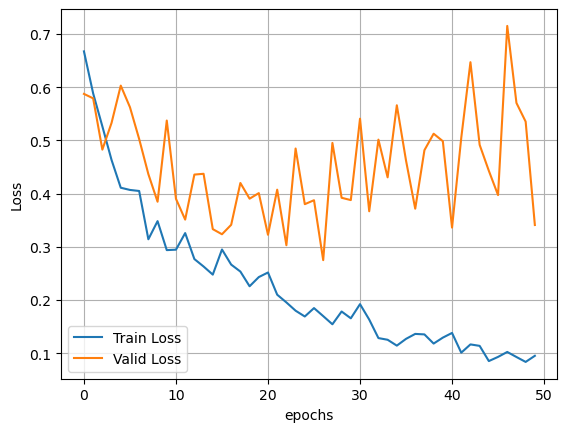

In [28]:
plt.plot( range(history.shape[0]), history["Train Loss"].values, label="Train Loss")
plt.plot( range(history.shape[0]), history["Valid Loss"].values, label="Valid Loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

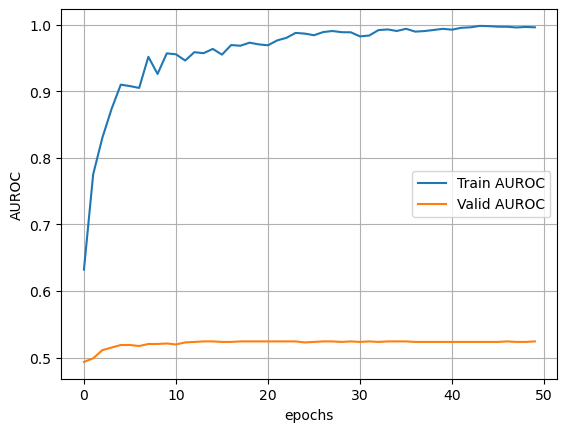

In [29]:
plt.plot( range(history.shape[0]), history["Train AUROC"].values, label="Train AUROC")
plt.plot( range(history.shape[0]), history["Valid AUROC"].values, label="Valid AUROC")
plt.xlabel("epochs")
plt.ylabel("AUROC")
plt.grid()
plt.legend()
plt.show()

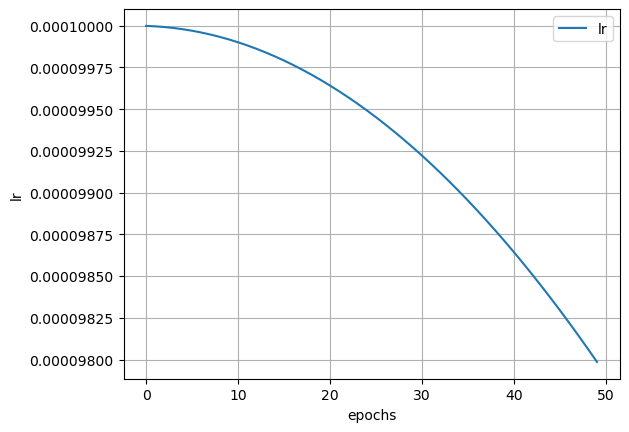

In [30]:
plt.plot( range(history.shape[0]), history["lr"].values, label="lr")
plt.xlabel("epochs")
plt.ylabel("lr")
plt.grid()
plt.legend()
plt.show()